Import

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import ferbo as fb
from tqdm.notebook import tqdm
importlib.reload(fb)
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
from utils import plot_vs_parameters
from theory import eingensystem_hamiltonian

In [32]:
Ej = 20
Ec = 50
r = 0.05
Nmax = 15

N_list = np.arange(-Nmax, Nmax + 1) / 2
dimension = 2 * (2*Nmax + 1)
phase_list = np.linspace(0, 4*np.pi, 101)
q_list = np.linspace(0,1/2, 100)[1:-1]

eigvals_list = np.zeros((len(q_list), dimension))
bloch_amplitudes_list = np.zeros((len(phase_list),len(q_list),dimension,2), dtype=np.complex128)
bloch_waves_list = np.zeros_like(bloch_amplitudes_list)

for i , phase in enumerate(tqdm(phase_list)):
    for j, q in enumerate(q_list):
        eigvals, eigvecs = eingensystem_hamiltonian(Ej, phase, r, Ec, q, Nmax)
        # if q >= 0: #Point of degeneracy
        #     for k in range(0, dimension, 2):
        #         eigvals[[k, k+1]] = eigvals[[k+1, k]]
                # eigvecs[[k, k+1]] = eigvecs[[k+1, k]]
        
        eigvals_list[j] = eigvals
        eigvecs_reshaped = eigvecs.reshape(dimension, -1, 2)
        phase_factor = np.exp(1j * N_list * phase)
        bloch_amplitudes_list[i,j] = np.einsum('nks,k->ns',eigvecs_reshaped,phase_factor)
        bloch_waves_list[i,j] = np.exp(1j * q * phase) * bloch_amplitudes_list[i,j]

derivative_bloch_amplitudes_list = np.gradient(bloch_amplitudes_list,q_list,axis=1, edge_order=2)
derivative_bloch_waves_list = np.gradient(bloch_waves_list,q_list,axis=1, edge_order=2)

product_tensor = np.zeros((len(phase_list),len(q_list), dimension, dimension), dtype= np.complex128)
product2_tensor = np.zeros_like(product_tensor)

# p: phase index. q: quasimomentum index. n & m : band index. s: spin index.
product_tensor = np.einsum('pqns,pqms->pqnm', np.conjugate(bloch_amplitudes_list), derivative_bloch_amplitudes_list)
product2_tensor = np.einsum('pqns,pqms->pqnm', np.conjugate(bloch_waves_list), derivative_bloch_waves_list)

Omega_tensor = 1j * np.trapz(product_tensor,phase_list,axis = 0)
Derivate_tensor = -1j * np.trapz(product2_tensor,phase_list,axis = 0)


  0%|          | 0/101 [00:00<?, ?it/s]

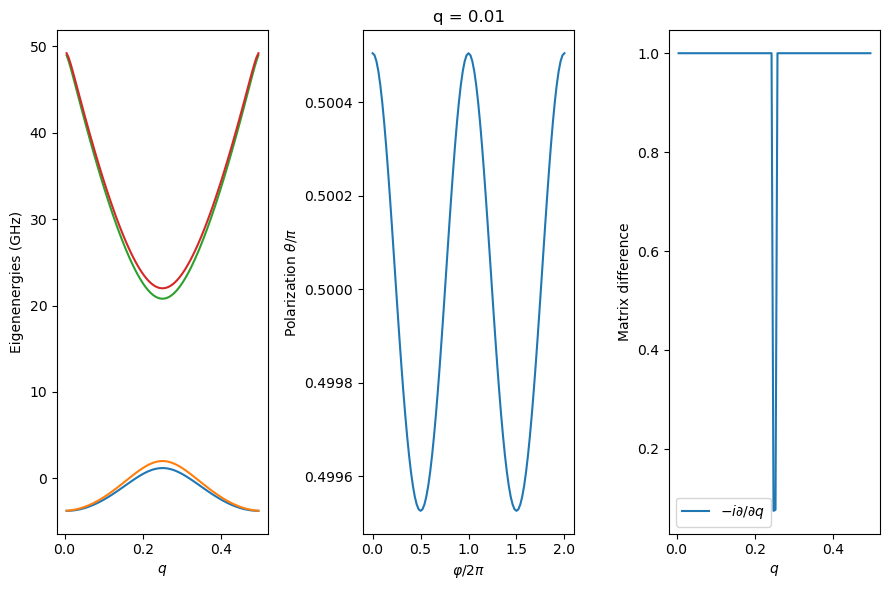

In [35]:
q_fix = 0
state_idx = 4
q_idx = np.argmin(np.abs(q_list-q_fix))

phase = np.diff(np.angle(bloch_amplitudes_list[:,q_idx,state_idx]))
mods = np.abs(bloch_amplitudes_list[:,q_idx,state_idx])
theta = 2* np.arctan(mods[:,0] /mods[:,1])

fig,ax = plt.subplots(1,3, figsize=(9,6))
ax[0].plot(q_list,eigvals_list[:,:4])
ax[1].plot(phase_list/2/np.pi, theta/np.pi)
# ax[1].plot(phase_list/2/np.pi, np.angle(bloch_amplitudes_list[:,26,1]))
ax[2].plot(q_list,np.linalg.norm(Derivate_tensor[:,:4,:4] + Omega_tensor[:,:4,:4], axis=(1,2))/np.linalg.norm(Derivate_tensor[:,:4,:4], axis=(1,2)), label=rf'$-i \partial / \partial q$')
# ax[2].plot(q_list*4,np.abs(Derivate_tensor[:,2,0]), label=rf'$-i \partial / \partial q$')
ax[0].set_ylabel(rf'Eigenenergies (GHz)')
ax[1].set_title(rf'q = {np.round(q_list[q_idx],2)}')
ax[1].set_ylabel(rf'Polarization $\theta/\pi$')
ax[2].set_ylabel(rf'Matrix difference')
ax[0].set_xlabel(rf'$q$')
ax[1].set_xlabel(rf'$q$')
ax[1].set_xlabel(rf'$\varphi/2\pi$')
ax[2].set_xlabel(rf'$q$')
ax[2].legend()
plt.tight_layout()
plt.show()

In [416]:
Ej = 20
Ec = 50
r = 0.2
Nmax = 50
phase = 2*np.pi

dimension = 2 * (2*Nmax + 1)
phase_list = np.linspace(-2*np.pi, 2*np.pi, 101)
q_list = np.linspace(-1/4, 1/4, 100)[1:-1]

eigvals_list = np.zeros((len(q_list), dimension))
bloch_amplitudes_list = np.zeros((len(q_list),dimension,2), dtype=np.complex128)
bloch_waves_list = np.zeros_like(bloch_amplitudes_list)

for j, q in enumerate(q_list):
    eigvals_list[j], bloch_amplitudes_list[j] = bloch_waves_generator(Ej, phase, r, Ec, q, Nmax)

ValueError: x and y must have same first dimension, but have shapes (98,) and (101, 42, 2)

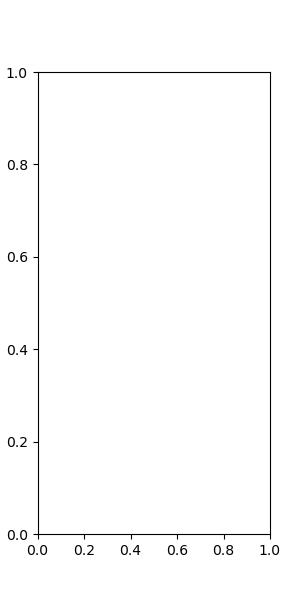

In [418]:
plt.close('all')
fig,ax = plt.subplots(1,1, figsize=(3,6))
ax.plot(q_list[:],np.abs(bloch_amplitudes_list[:,0]))
ax.plot(q_list[:],np.abs(bloch_amplitudes_list[:,1]))
ax.set_xlabel(rf'$q$')
ax.set_ylabel(rf'Eigenenergies')
plt.tight_layout()
plt.show()

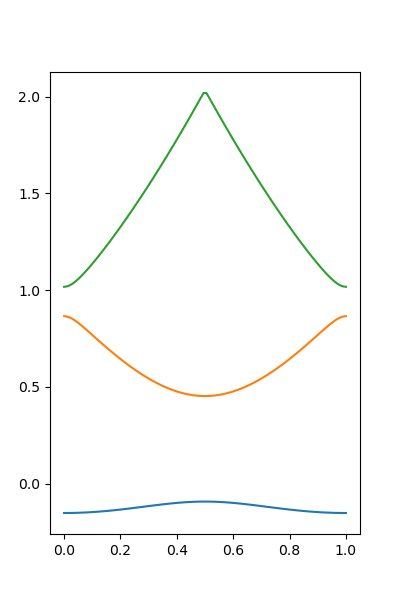

In [25]:
from qutip import charge, tunneling
import matplotlib.pyplot as plt
Nmax = 10
dimension = 2*Nmax + 1
eigvals = 3
Ec, Ej = 1, 2.5
ng_array = np.linspace(0,1, 100)
eigvals_array = np.zeros((len(ng_array),eigvals))
for i, ng in enumerate(ng_array):
    transmon = 4*Ec*(charge(Nmax,-Nmax)-ng)**2 - 0.5*Ej*tunneling(dimension)
    eigvals_array[i], eigvecs = transmon.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (4,6))
ax.plot(ng_array,eigvals_array/np.sqrt(8*Ej*Ec))
plt.show()

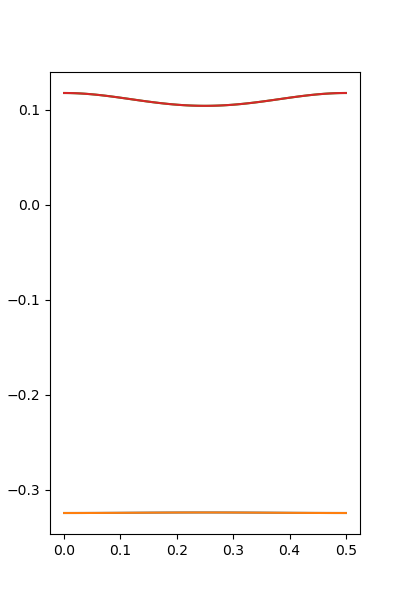

In [5]:
from qutip import charge, tunneling, tensor, sigmaz, qeye
import matplotlib.pyplot as plt
Nmax = 10
dimension = 2*Nmax + 1
eigvals = 4
Ec, Ej = 1, 2.5
ng_array = np.linspace(0,1/2, 100)
eigvals_array = np.zeros((len(ng_array),eigvals))
for i, ng in enumerate(ng_array):
    andreev = 4*Ec*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) - 0.5*Ej*tensor(tunneling(dimension), sigmaz()) 
    eigvals_array[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (4,6))
ax.plot(ng_array,eigvals_array/np.sqrt(8*Ej*Ec))
plt.show()

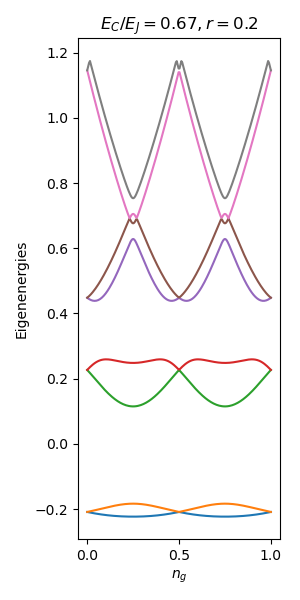

In [30]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
import matplotlib.pyplot as plt
Nmax = 20
r = 0.2
phi_ext = 0
dimension = 2*Nmax + 1
eigvals = 8
Ec, Ej = 1,1.5
ng_array = np.linspace(0,1, 200)
eigvals_array = np.zeros((len(ng_array),eigvals))
for i, ng in enumerate(ng_array):
    andreev = 4*Ec*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (3,6))
ax.plot(ng_array,eigvals_array/np.sqrt(8*Ej*Ec))
ax.set_title(rf'$E_C/E_J = {round(Ec/Ej, 2)}, r = {r}$')
ax.set_xlabel(rf'$n_g$')
ax.set_ylabel(rf'Eigenenergies')
fig.tight_layout()
plt.show()

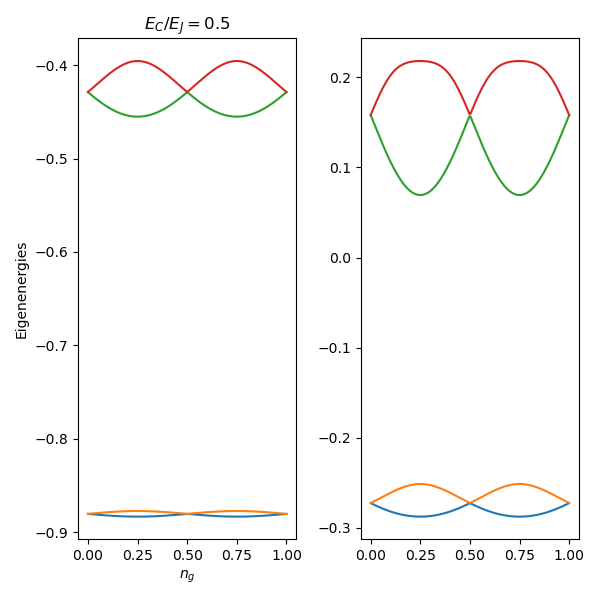

In [41]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
import matplotlib.pyplot as plt
Nmax = 20
r = 0.2
phi_ext = 0
dimension = 2*Nmax + 1
eigvals = 4
ng_array = np.linspace(0,1, 200)
eigvals_array1 = np.zeros((len(ng_array),eigvals))
eigvals_array2 = np.zeros((len(ng_array),eigvals))

Ec1,Ej = 0.1,1
for i, ng in enumerate(ng_array):
    andreev = 4*Ec1*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array1[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

Ec2,Ej = 0.5,1
for i, ng in enumerate(ng_array):
    andreev = 4*Ec2*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array2[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(1,2,figsize = (6,6))
ax[0].plot(ng_array,eigvals_array1/np.sqrt(8*Ej*Ec1))
ax[1].plot(ng_array,eigvals_array2/np.sqrt(8*Ej*Ec2))
ax[0].set_title(rf'$E_C/E_J = {round(Ec1/Ej, 2)}$')
ax[1].set_title(rf'$E_C/E_J = {round(Ec2/Ej, 2)}$')
ax[0].set_xlabel(rf'$n_g$')
ax[0].set_ylabel(rf'Eigenenergies')
fig.tight_layout()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

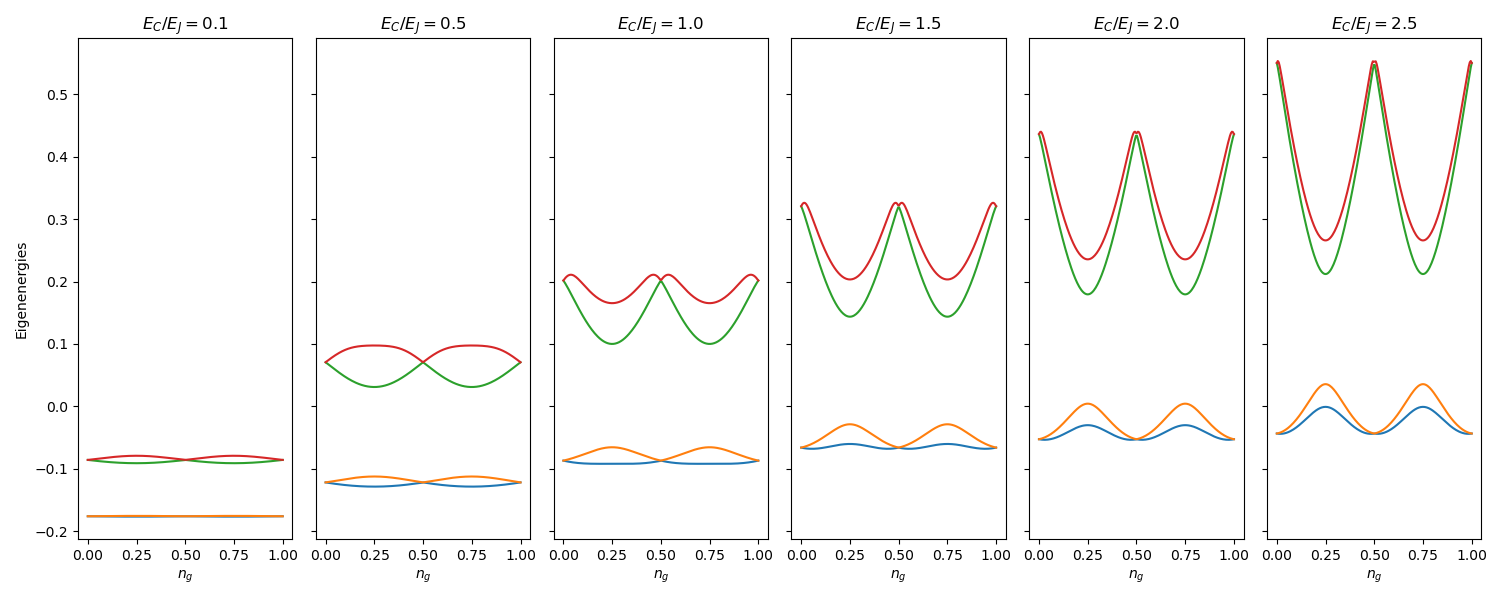

In [8]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
from operators import cos_phi, sin_phi
from utils import plot_vs_parameters
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Definir los valores de Ec que deseas considerar
Ec_values = [0.1, 0.5, 1, 1.5, 2, 2.5]

Nmax = 20
r = 0.2
phi_ext = 0
dimension = 2 * Nmax + 1
eigvals = 4
ng_array = np.linspace(0, 1, 200)

# Crear una lista para almacenar los arrays de eigvals correspondientes a cada valor de Ec
eigvals_arrays = []

Ej = 1

# Iterar a través de los valores de Ec
for Ec in tqdm(Ec_values):
    eigvals_array = np.zeros((len(ng_array), eigvals))
    
    for i, ng in enumerate(ng_array):
        andreev = 4 * Ec * tensor((charge(Nmax, -Nmax, frac=1/2) - ng)**2, qeye(2)) + Ej * (tensor(cos_phi(dimension, phi_ext, m=1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m=1), sigmay()))
        eigvals_array[i], eigvecs = andreev.eigenstates(eigvals=eigvals)
    
    # Agregar el array de eigvals a la lista
    eigvals_arrays.append(eigvals_array)

# Crear subplots para cada valor de Ec
x_values_list = [ng_array] * len(Ec_values)
y_values_list = [eigvals_array / np.sqrt(8 * Ej * Ec) for eigvals_array in eigvals_arrays]
parameter_names = [rf'$n_g$'] * len(Ec_values)
ylabels = [rf'Eigenenergies'] * len(Ec_values)
titles = [rf'$E_C/E_J = {round(Ec/Ej, 2)}$' for Ec in Ec_values]

plot_vs_parameters(x_values_list, y_values_list, parameter_names, ylabels, titles, sharey = True)


  0%|          | 0/6 [00:00<?, ?it/s]

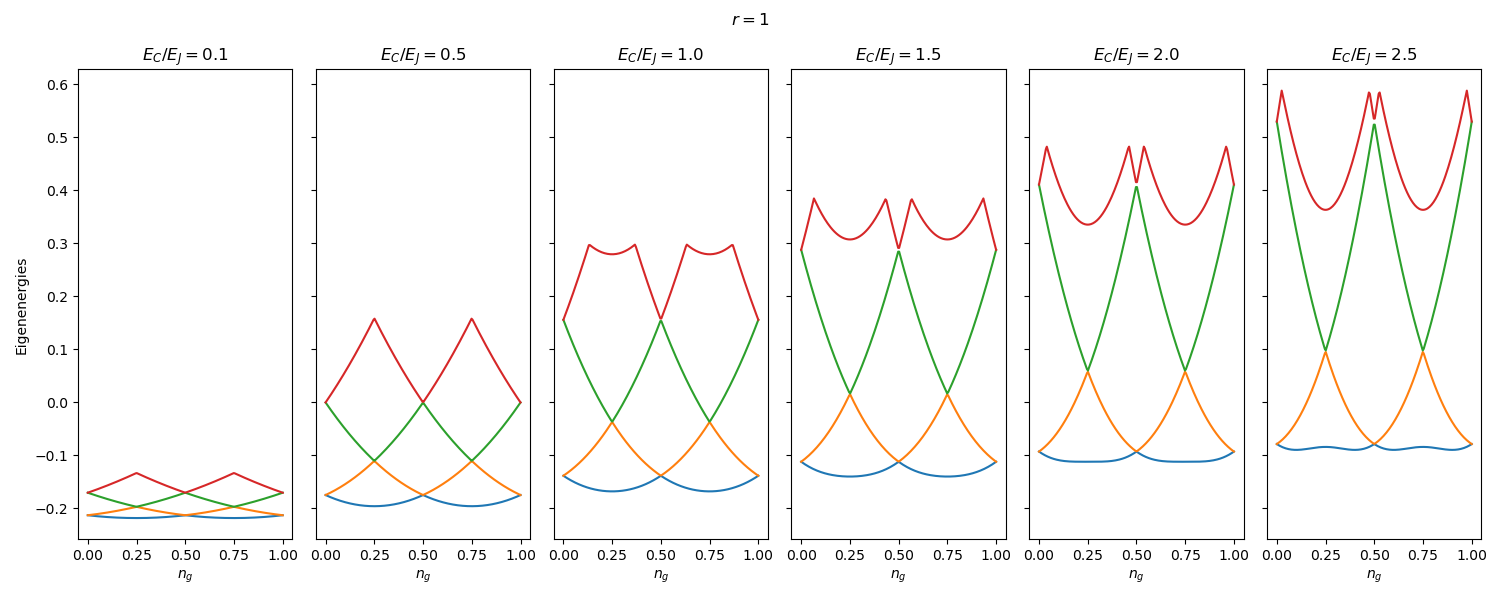

In [19]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
from operators import cos_phi, sin_phi
from utils import plot_vs_parameters
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Definir los valores de Ec que deseas considerar
Ec_values = [0.1, 0.5, 1, 1.5, 2, 2.5]

Nmax = 20
r = 1
phi_ext = 0
dimension = 2 * Nmax + 1
eigvals = 4
ng_array = np.linspace(0, 1, 200)

# Crear una lista para almacenar los arrays de eigvals correspondientes a cada valor de Ec
eigvals_arrays = []

Ej = 1

# Iterar a través de los valores de Ec
for Ec in tqdm(Ec_values):
    eigvals_array = np.zeros((len(ng_array), eigvals))
    
    for i, ng in enumerate(ng_array):
        andreev = 4 * Ec * tensor((charge(Nmax, -Nmax, frac=1/2) - ng)**2, qeye(2)) + Ej * (tensor(cos_phi(dimension, phi_ext, m=1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m=1), sigmay()))
        eigvals_array[i], eigvecs = andreev.eigenstates(eigvals=eigvals)
    
    # Agregar el array de eigvals a la lista
    eigvals_arrays.append(eigvals_array)

# Crear subplots para cada valor de Ec
x_values_list = [ng_array] * len(Ec_values)
y_values_list = [eigvals_array / np.sqrt(8 * Ej * Ec) for eigvals_array in eigvals_arrays]
parameter_names = [rf'$n_g$'] * len(Ec_values)
ylabels = [rf'Eigenenergies'] * len(Ec_values)
titles = [rf'$E_C/E_J = {round(Ec/Ej, 2)}$' for Ec in Ec_values]

plot_vs_parameters(x_values_list, y_values_list, parameter_names, ylabels, titles, common_title=rf'$r = {r}$',sharey = True)


  0%|          | 0/8 [00:00<?, ?it/s]

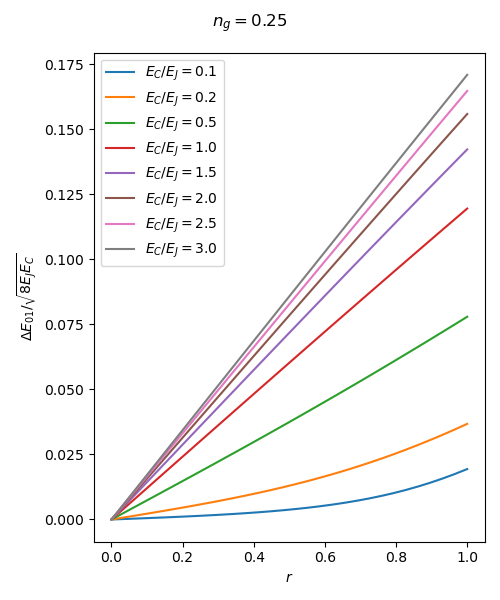

In [30]:
from qutip import charge, tensor, sigmaz, sigmay, qeye
from operators import cos_phi, sin_phi
from utils import plot_vs_parameters
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Definir los valores de Ec que deseas considerar
Ec_values = [0.1,0.2, 0.5, 1, 1.5, 2, 2.5, 3]

Nmax = 20
phi_ext = 0
dimension = 2 * Nmax + 1
eigvals = 2
ng = 0.25
r_array = np.linspace(0, 1, 30)
# Crear una lista para almacenar los arrays de eigvals correspondientes a cada valor de Ec
dif_arrays = []

Ej = 1

# Iterar a través de los valores de Ec
for Ec in tqdm(Ec_values):
    dif_array = np.zeros(len(r_array))
    
    for i, r in enumerate(r_array):
        andreev = 4 * Ec * tensor((charge(Nmax, -Nmax, frac=1/2) - ng)**2, qeye(2)) + Ej * (tensor(cos_phi(dimension, phi_ext, m=1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m=1), sigmay()))
        eigvals, eigvecs = andreev.eigenstates(eigvals=4)
        dif = eigvals[1] - eigvals[0]
        dif_array[i] = dif
    
    # Agregar el array de eigvals a la lista
    dif_arrays.append(dif_array)

# Crear subplots para cada valor de Ec
x_values_list = [r_array] * len(Ec_values)
y_values_list = [dif_array/ np.sqrt(8 * Ej * Ec) for dif_array in dif_arrays]
parameter_names = [rf'$r$'] * len(Ec_values)
ylabels = [rf'$\Delta E_{{01}} / \sqrt{{8 E_J E_C}}$'] * len(Ec_values)
titles = [rf'$E_C/E_J = {round(Ec/Ej, 2)}$' for Ec in Ec_values]

plot_vs_parameters(x_values_list, y_values_list, parameter_names, ylabels, titles, common_title=rf'$n_g = {ng}$',sharey = True, single_plot=True, figsize=(5,6))


# Quasimomentum

## Transmon

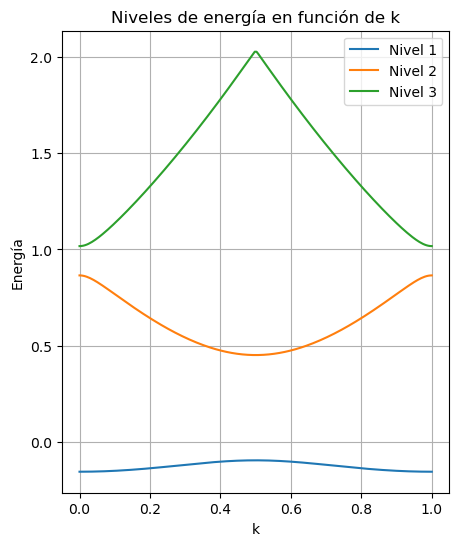

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
Ec_value = 1  # Puedes reemplazar esto con el valor que desees
Ej_value = 2.5  # Puedes reemplazar esto con el valor que desees

k_values = np.linspace(0, 1, 200)  # Rango de valores para k
eigenvalues_list = []

def create_matrix(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i)**2
        matrix[i, i-1] = Ej_value / 2
        matrix[i-1, i] = Ej_value / 2
    return matrix

for k in k_values:
    matrix_k = create_matrix(k)
    eigenvalues_k = np.linalg.eigvalsh(matrix_k)
    eigenvalues_list.append(eigenvalues_k)

eigenvalues_array = np.array(eigenvalues_list)

# Gráfica de los niveles de energía en función de k
plt.figure(figsize=(5, 6))
for i in range(3):
    plt.plot(k_values, eigenvalues_array[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")

plt.xlabel("k")
plt.ylabel("Energía")
plt.title("Niveles de energía en función de k")
plt.legend()
plt.grid(True)
plt.show()

## Andreev spin qubit

In [78]:
Ej = 1
r = 0.05
Ec = 2.5
Nmax = 4

def swap_pairs(array):
    # Iterar sobre los elementos del array en pasos de 2
    for i in range(0, len(array) - 1, 2):
        # Intercambiar los elementos
        array[i], array[i + 1] = array[i + 1], array[i]
    return array

phi_list = np.linspace(0, 4 * np.pi, 70)
m_val = np.arange(-N, N + 2) // 2
q_list = np.linspace(-1/10,-0.0001, 80)
num_q = len(q_list)
num_bands = len(m_val)

# Tensor para almacenar los productos
product_tensor = np.zeros((len(phi_list),num_q, num_bands, num_bands), dtype=complex)
bloch_waves_list = []

for phi in phi_list:
    phase = np.exp(1j * m_val / 2 * phi)
    bloch_waves_per_phi = []
    for q in q_list:    
        hamiltonian = bloch_andreev_hamiltonian(Ej=Ej, r=r, Ec=Ec, q=q, Nmax=Nmax)
        _, eigenvectors = np.linalg.eigh(hamiltonian)
        # if q >= 0:
        #     eigenvectors = swap_pairs(eigenvectors)
        bloch_waves = eigenvectors * phase
        bloch_waves_per_phi.append(bloch_waves)
    
    bloch_waves_list.append(bloch_waves_per_phi)

bloch_waves_list = np.array(bloch_waves_list) #[phi,q,n]
dudq_list = np.gradient(bloch_waves_list, q_list, axis=1)

for phi_idx in range(len(phi_list)):
    for q in range(num_q):
        for n in range(num_bands):
            for m in range(num_bands):
                product_tensor[phi_idx, q, n, m] = 1j * np.vdot(bloch_waves_list[phi_idx, q, n], dudq_list[phi_idx ,q, m])

Omega_tensor = np.trapz(product_tensor,phi_list, axis= 0)

In [79]:
print(Omega_tensor[-1,:2,:2])

[[-1.29404976e-14+5179.06129798j -7.76429857e-15-5137.68983542j]
 [ 3.29982689e-14-5137.68983542j -1.74696718e-14+5179.06129798j]]


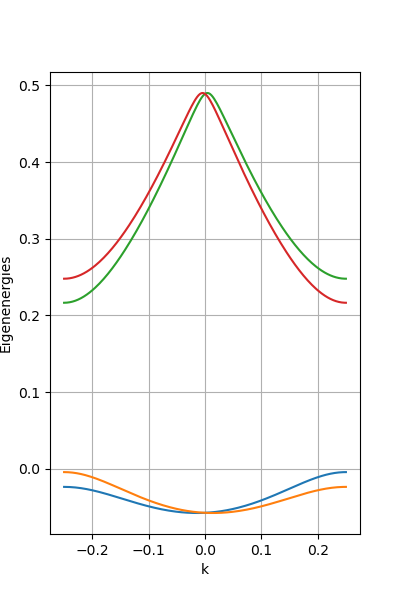

In [73]:
# Parámetros
Ej = 1
r = 0.1
Ec = 2
k_values = np.linspace(-1/4,1/4,200)
N = 20  # Tamaño de la matriz, debe ser múltiplo de 4 para este ejemplo
eigenvalues_list_full = []
eigenvectors_list_full = []

def swap_pairs(array):
    # Iterar sobre los elementos del array en pasos de 2
    for i in range(0, len(array) - 1, 2):
        # Intercambiar los elementos
        array[i], array[i + 1] = array[i + 1], array[i]
    return array


for k in k_values:
    matrix_k = bloch_andreev_hamiltonian(Ej, r, Ec, k, N)
    eigenvalues_k,eigenvectors_k  = np.linalg.eigh(matrix_k)
    if k > 0:
        eigenvalues_k = swap_pairs(eigenvalues_k)
        eigenvectors_k = swap_pairs(eigenvectors_k)
    eigenvalues_list_full.append(eigenvalues_k)
    eigenvectors_list_full.append(eigenvectors_k)

eigenvalues_array_full  = np.array(eigenvalues_list_full)

plt.close('all')
plt.figure(figsize=(4, 6))
for i in range(4):
    plt.plot(k_values, eigenvalues_array_full[:, i]/np.sqrt(8*Ec*Ej))

plt.xlabel("k")
plt.ylabel("Eigenenergies")
plt.grid(True)
plt.show()

In [17]:
k_values = np.linspace(-1/4,1/4,200)
N = 20  # Tamaño de la matriz, debe ser múltiplo de 4 para este ejemplo
eigenvalues_list = []
eigenvectors_list = []

matrix_k = bloch_andreev_hamiltonian(Ej, r, Ec, -1/8, N)
eigenvalues_k,eigvecs = np.linalg.eigh(matrix_k)
eigvecs[0]

array([-8.68359098e-21,  1.08594728e-20, -7.52490830e-20,  3.34224044e-20,
        1.90417295e-21,  3.87442684e-21, -1.88539971e-18,  1.91578232e-18,
        4.16374041e-23,  3.99787670e-23, -2.49846530e-16,  1.07901034e-16,
        1.15441299e-25,  2.63900960e-25, -2.25909509e-14,  2.26902651e-14,
        3.06671991e-28,  3.02807645e-28, -6.29543770e-12,  2.70546239e-12,
        1.66148421e-31,  3.84288946e-31, -8.76171919e-10,  8.77771587e-10,
        8.36853738e-35,  8.30228618e-35, -2.98784674e-07, -1.28205022e-07,
        3.45877377e-38,  8.04145561e-38,  4.11206758e-05, -4.11542249e-05,
        0.00000000e+00,  0.00000000e+00, -1.06987030e-02, -4.58686690e-03,
        0.00000000e+00,  0.00000000e+00, -7.07091903e-01, -7.07025838e-01,
        0.00000000e+00,  0.00000000e+00])

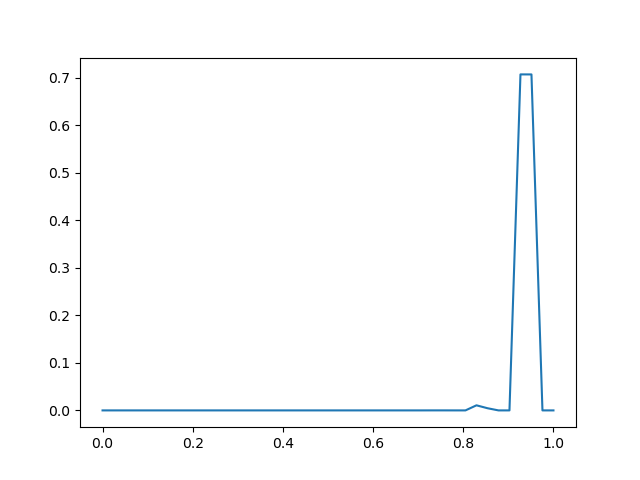

In [47]:
matrix_k = bloch_andreev_hamiltonian(Ej, r, Ec, -1/8, N)
eigenvalues_k,eigvecs = np.linalg.eigh(matrix_k)
np.abs(eigvecs[0])
plt.close('all')
plt.plot(np.linspace(0,1,len(eigvecs[0])),np.abs(eigvecs[0]))
plt.show()

In [67]:
np.arange(-3//2,3//2+1)

array([-2, -1,  0,  1])

In [110]:
from sympy import Matrix, symbols

Ej, r, Ec, k = symbols('Ej r Ec k')

def generate_sympy_matrix(Ej, r, Ec, k, N):
    # Inicializar matriz de ceros
    matrix = Matrix.zeros(2*(N+1))
    
    # Llenar la diagonal principal y las sub-diagonales
    for i,idx in enumerate(np.arange(-N,N+2)):

        k_val = k - (idx // 2) / 2
        if matrix[i, i] == 0:
            matrix[i, i] = 4 * Ec * k_val ** 2

        # Llenar las sub-diagonales y super-diagonales
        if i + 1 < 2*(N+1):
            matrix[i, i + 1] = 0 if i % 2 == 0 else -r * Ej / 2
            matrix[i + 1, i] = 0 if i % 2 == 0 else -r * Ej / 2
            
        if i + 2 < 2*(N+1):
            matrix[i, i + 2] = Ej / 2 if i % 2 == 0 else -Ej / 2
            matrix[i + 2, i] = Ej / 2 if i % 2 == 0 else -Ej / 2

        if i + 3 < 2*(N+1):
            matrix[i, i + 3] = -r * Ej / 2 if i % 2 == 0 else 0
            matrix[i + 3, i] = r * Ej / 2 if i % 2 == 0 else 0
    return matrix

N = 6  # Tamaño de la matriz, debe ser múltiplo de 4

# Generar la matriz simbólica
matrix_sympy = generate_sympy_matrix(Ej, r, Ec, k, N)

# Mostrar la matriz
print("Matriz simbólica generada:")
print(matrix_sympy)


Matriz simbólica generada:
Matrix([[9.0*Ec*(0.666666666666667*k + 1)**2, 0, Ej/2, -Ej*r/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 9.0*Ec*(0.666666666666667*k + 1)**2, -Ej*r/2, -Ej/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [Ej/2, -Ej*r/2, 4*Ec*(k + 1.0)**2, 0, Ej/2, -Ej*r/2, 0, 0, 0, 0, 0, 0, 0, 0], [Ej*r/2, -Ej/2, 0, 4*Ec*(k + 1.0)**2, -Ej*r/2, -Ej/2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, Ej/2, -Ej*r/2, 4*Ec*(k + 0.5)**2, 0, Ej/2, -Ej*r/2, 0, 0, 0, 0, 0, 0], [0, 0, Ej*r/2, -Ej/2, 0, 4*Ec*(k + 0.5)**2, -Ej*r/2, -Ej/2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, Ej/2, -Ej*r/2, 4*Ec*k**2, 0, Ej/2, -Ej*r/2, 0, 0, 0, 0], [0, 0, 0, 0, Ej*r/2, -Ej/2, 0, 4*Ec*k**2, -Ej*r/2, -Ej/2, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, Ej/2, -Ej*r/2, 4*Ec*(k - 0.5)**2, 0, Ej/2, -Ej*r/2, 0, 0], [0, 0, 0, 0, 0, 0, Ej*r/2, -Ej/2, 0, 4*Ec*(k - 0.5)**2, -Ej*r/2, -Ej/2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, Ej/2, -Ej*r/2, 4*Ec*(k - 1.0)**2, 0, Ej/2, -Ej*r/2], [0, 0, 0, 0, 0, 0, 0, 0, Ej*r/2, -Ej/2, 0, 4*Ec*(k - 1.0)**2, -Ej*r/2, -Ej/2], [0, 0, 0, 0, 0, 0, 0,

In [111]:
from sympy import pprint
pprint(matrix_sympy, use_unicode=True)

⎡                                2                                           E
⎢9.0⋅Ec⋅(0.666666666666667⋅k + 1)                   0                        ─
⎢                                                                            2
⎢                                                                             
⎢                                                                   2      -Ej
⎢                0                  9.0⋅Ec⋅(0.666666666666667⋅k + 1)       ───
⎢                                                                            2
⎢                                                                             
⎢               Ej                               -Ej⋅r                        
⎢               ──                               ──────                4⋅Ec⋅(k
⎢               2                                  2                          
⎢                                                                             
⎢              Ej⋅r                               -E

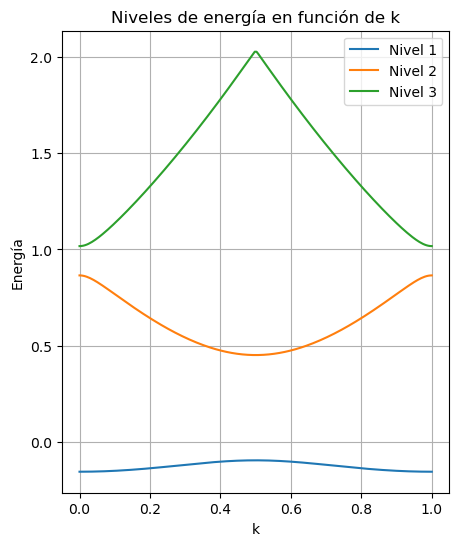

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
Ec_value = 1  # Puedes reemplazar esto con el valor que desees
Ej_value = 2.5  # Puedes reemplazar esto con el valor que desees

k_values = np.linspace(0, 1, 200)  # Rango de valores para k
eigenvalues_list = []

def create_matrix_andreev(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = Ej_value / 2
        matrix[i-1, i] = Ej_value / 2
    return matrix

for k in k_values:
    matrix_k = create_matrix_andreev(k)
    eigenvalues_k = np.linalg.eigvalsh(matrix_k)
    eigenvalues_list.append(eigenvalues_k)

eigenvalues_array = np.array(eigenvalues_list)

# Gráfica de los niveles de energía en función de k
plt.figure(figsize=(5, 6))
for i in range(3):
    plt.plot(k_values, eigenvalues_array[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")

plt.xlabel("k")
plt.ylabel("Energía")
plt.title("Niveles de energía en función de k")
plt.legend()
plt.grid(True)
plt.show()

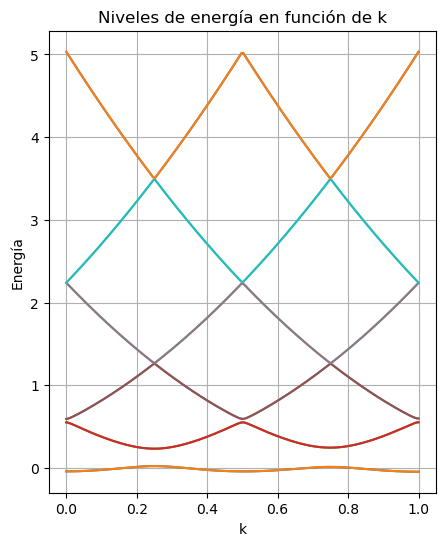

In [20]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
Ec_value = 2.5  # Puedes reemplazar esto con el valor que desees
Ej_value = 1  # Puedes reemplazar esto con el valor que desees
r = 0.05

k_values = np.linspace(0, 1, 200)  # Rango de valores para k
eigenvalues_list_up = []
eigenvalues_list_down = []

def create_matrix_up(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = (1+r)* Ej_value / 2
        matrix[i-1, i] = (1-r)* Ej_value / 2
    return matrix

def create_matrix_down(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = -(1+r)* Ej_value / 2
        matrix[i-1, i] = -(1-r)* Ej_value / 2
    return matrix

for k in k_values:
    matrix_k_up = create_matrix_up(k)
    eigenvalues_k_up = np.linalg.eigvalsh(matrix_k_up)
    eigenvalues_list_up.append(eigenvalues_k_up)

eigenvalues_array_up = np.array(eigenvalues_list_up)

for k in k_values:
    matrix_k_down = create_matrix_down(k)
    eigenvalues_k_down = np.linalg.eigvalsh(matrix_k_down)
    eigenvalues_list_down.append(eigenvalues_k_down)

eigenvalues_array_down = np.array(eigenvalues_list_down)
# Gráfica de los niveles de energía en función de k
plt.figure(figsize=(5, 6))
for i in range(6):
    plt.plot(k_values, eigenvalues_array_up[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")
    plt.plot(k_values, eigenvalues_array_down[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")

plt.xlabel("k")
plt.ylabel("Energía")
plt.title("Niveles de energía en función de k")
# plt.legend()
plt.grid(True)
plt.show()

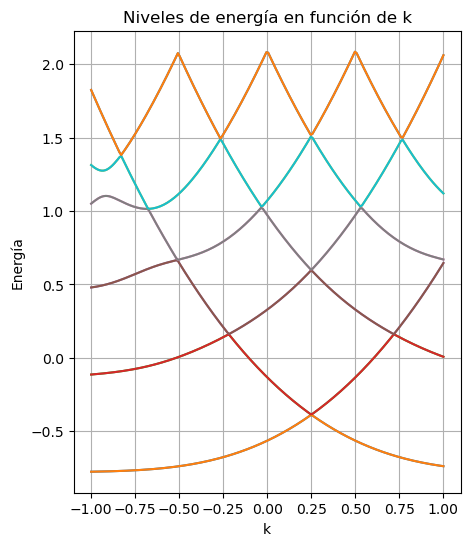

In [23]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
Ec_value = 1  # Puedes reemplazar esto con el valor que desees
Ej_value = 2.5  # Puedes reemplazar esto con el valor que desees
r = 0.2

k_values = np.linspace(-1, 1, 200)  # Rango de valores para k
eigenvalues_list = []

def create_matrix_andreev(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i+1] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = (1+r)* Ej_value / 2
        matrix[i-1, i] = (1-r)* Ej_value / 2
    return matrix

def create_matrix_down(k_val):
    # Inicializa matriz con ceros
    matrix = np.zeros((N, N))
    # Rellena la diagonal principal y las dos diagonales secundarias
    for i in np.arange(-N//2, N//2+1,1):
        matrix[i, i] = 4 * Ec_value * (k_val + i/2)**2
        matrix[i, i-1] = -(1+r)* Ej_value / 2
        matrix[i-1, i] = -(1-r)* Ej_value / 2
    return matrix

for k in k_values:
    matrix_k_up = create_matrix_up(k)
    eigenvalues_k_up = np.linalg.eigvalsh(matrix_k_up)
    eigenvalues_list_up.append(eigenvalues_k_up)

eigenvalues_array_up = np.array(eigenvalues_list_up)

for k in k_values:
    matrix_k_down = create_matrix_down(k)
    eigenvalues_k_down = np.linalg.eigvalsh(matrix_k_down)
    eigenvalues_list_down.append(eigenvalues_k_down)

eigenvalues_array_down = np.array(eigenvalues_list_down)
# Gráfica de los niveles de energía en función de k
plt.figure(figsize=(5, 6))
for i in range(6):
    plt.plot(k_values, eigenvalues_array_up[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")
    plt.plot(k_values, eigenvalues_array_down[:, i]/np.sqrt(8*Ec_value*Ej_value), label=f"Nivel {i+1}")

plt.xlabel("k")
plt.ylabel("Energía")
plt.title("Niveles de energía en función de k")
# plt.legend()
plt.grid(True)
plt.show()

In [37]:
from qutip import charge, tensor, sigmaz, sigmay, qeye, sigmax
import matplotlib.pyplot as plt
Nmax = 10
r = 0.8
ng = 0
dimension = 2*Nmax + 1
eigvals = 8
Ec, Ej = 1,2
phi_array = np.linspace(0,2*np.pi, 100)
eigvals_array = np.zeros((len(phi_array),eigvals))
for i, phi_ext in enumerate(phi_array):
    andreev = 4*Ec*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (3,4))
ax.plot(phi_array,eigvals_array/np.sqrt(8*Ej*Ec))
fig.tight_layout()
plt.show()

NameError: name 'cos_phi' is not defined

Tests

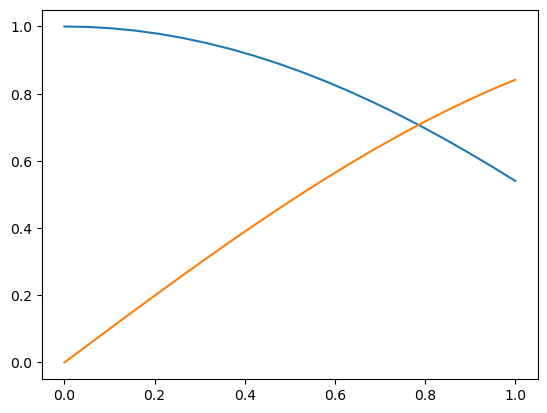

In [8]:
x = np.linspace(0,1,20)
y = np.array([np.cos(x),np.sin(x)]).T
plt.plot(x,y)


  0%|          | 0/100 [00:00<?, ?it/s]

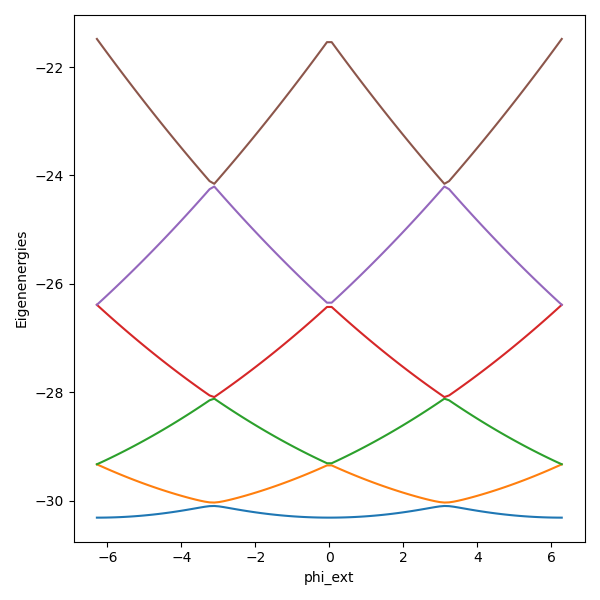

In [43]:
fixed_params = {
    'Ec': 5,
    'El': 0.05,
    'Delta': 40,
    'r': 0.05,
    'dimension': 100
}

phi_ext_array = np.linspace(-2*np.pi, 2*np.pi, 100)

eigenenergies = fb.eigenenergies_vs_parameter('phi_ext', phi_ext_array, fixed_params)

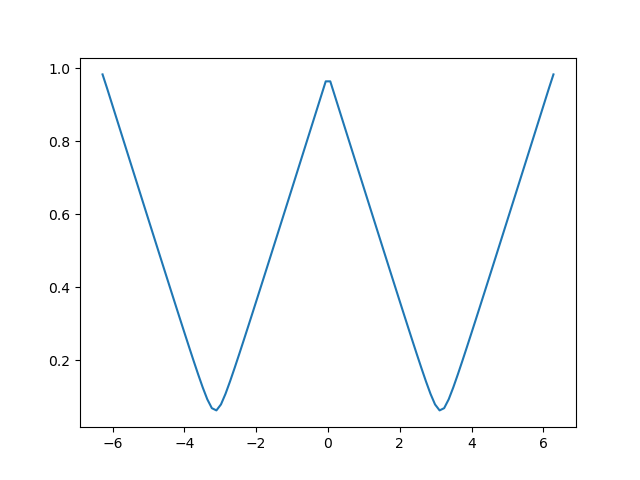

In [54]:
plt.close('all')
plt.plot(phi_ext_array,eigenenergies[:,1]-eigenenergies[:,0])
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

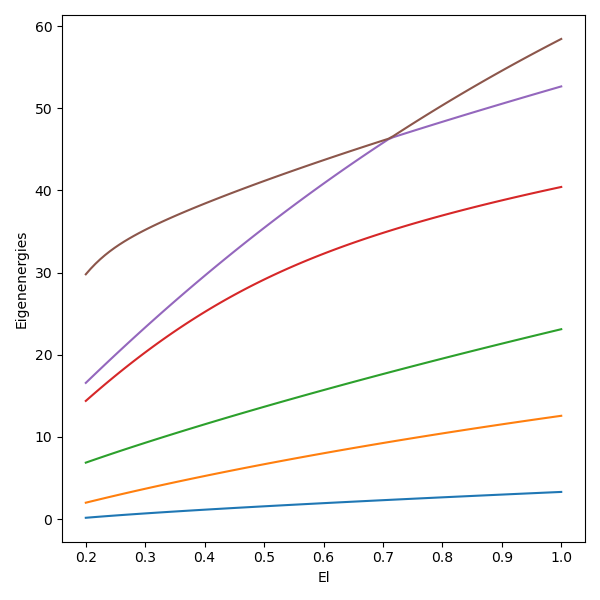

In [67]:
fixed_params = {
    'Ec': 60,
    'Delta': 20,
    'phi_ext': 0,
    'r' : 0.05,
    'dimension': 100
}

El_array = np.linspace(0.2, 1, 100)

eigenenergies = fb.eigenenergies_vs_parameter('El', El_array, fixed_params)

In [ ]:
plt.close('all')
plt.plot(El_array,)

  0%|          | 0/100 [00:00<?, ?it/s]

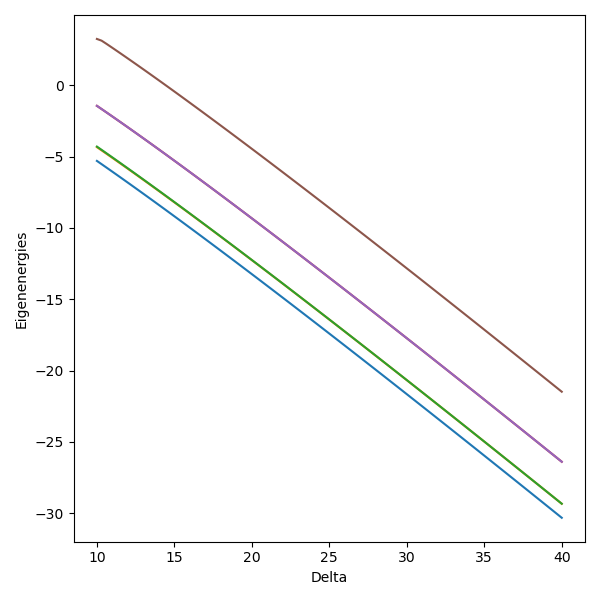

In [66]:
fixed_params = {
    'Ec': 5,
    'El': 0.05,
    'phi_ext': 0,
    'r' : 0.05,
    'dimension': 100
}

Delta_array = np.linspace(10, 40, 100)

eigenenergies = fb.eigenenergies_vs_parameter('Delta', Delta_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

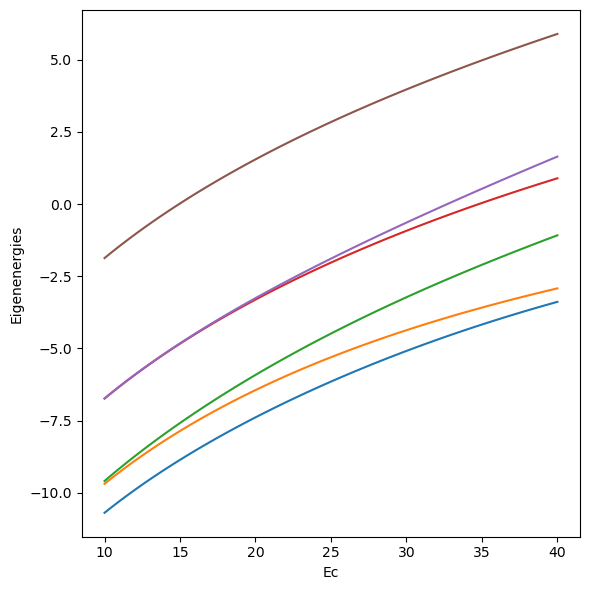

In [34]:
fixed_params = {
    'El': 0.05,
    'Delta' : 20,
    'phi_ext': 0,
    'r' : 0.05,
    'dimension': 100
}

Ec_array = np.linspace(10, 40, 100)

eigenenergies = fb.eigenenergies_vs_parameter('Ec', Ec_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

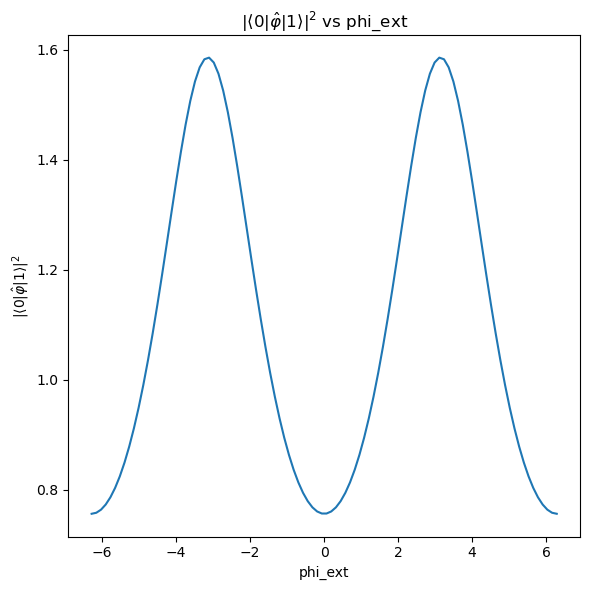

In [32]:
fixed_params = {
    'Ec': 50,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'dimension': 100
}

phi_ext_array = np.linspace(-2*np.pi, 2*np.pi, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

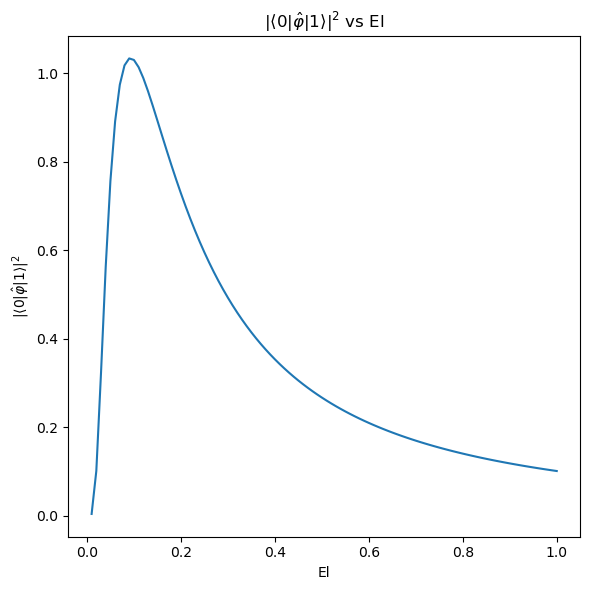

In [33]:
fixed_params = {
    'Ec': 50,
    'Delta': 20,
    'r': 0.05,
    'phi_ext': 0,
    'dimension': 100
}

El_array = np.linspace(0.01, 1, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='El', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

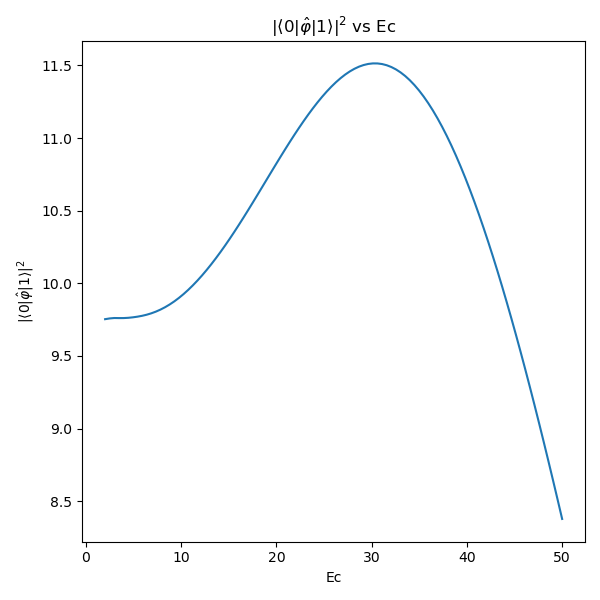

In [62]:
fixed_params = {
    'El': 0.05,
    'Delta': 40,
    'r': 0.05,
    'phi_ext': np.pi,
    'dimension': 100
}

Ec_array = np.linspace(2, 50, 100)

%matplotlib widget
matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='Ec', parameter_values=Ec_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

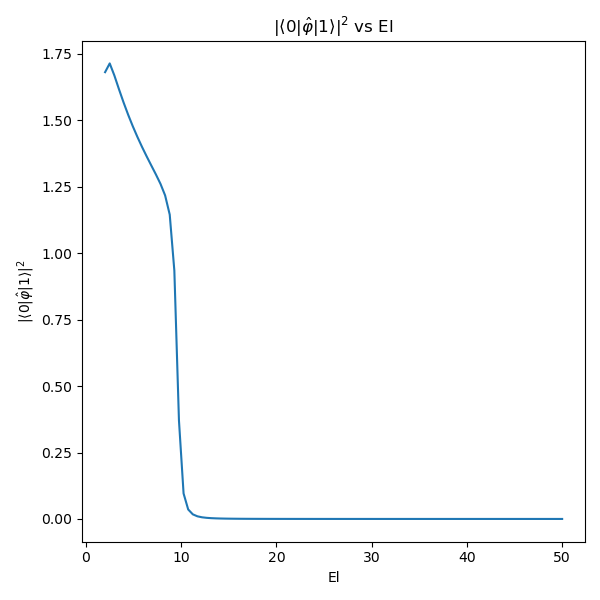

In [65]:
fixed_params = {
    'Ec': 10,
    'Delta': 20,
    'r': 0.05,
    'phi_ext': 0,
    'dimension': 100
}

El_array = np.linspace(0.05, 5, 200)

%matplotlib widget
matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='El', parameter_values=Ec_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

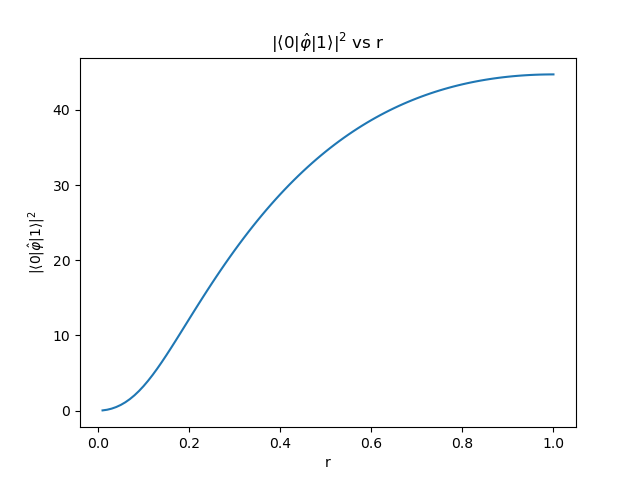

  0%|          | 0/100 [00:00<?, ?it/s]

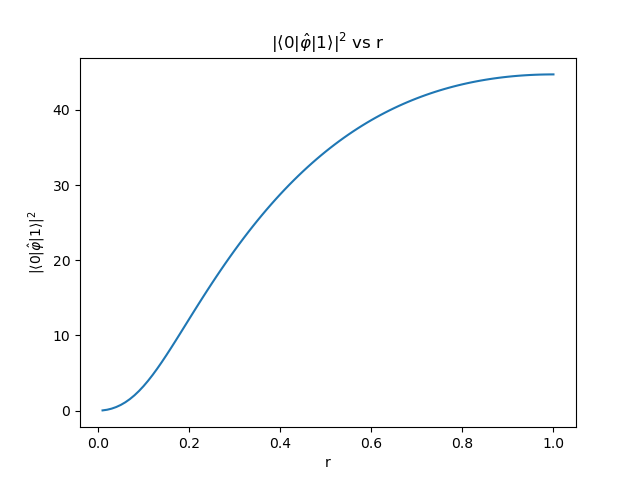

In [ ]:
fixed_params = {
    'Ec': 50,
    'El': 0.05,
    'Delta': 20,
    'phi_ext': 0,
    'dimension': 100
}

r_array = np.linspace(0, 1, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='r', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)